In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("per100stats.csv")
df.head()

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Awards,Player-additional
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9999
1,1.0,Mikal Bridges,28.0,NYK,SF,82.0,82.0,3036.0,9.7,19.3,...,5.0,1.2,0.7,2.2,2.1,23.6,117.0,118.0,NaN,bridgmi01
2,2.0,Josh Hart,29.0,NYK,SG,77.0,77.0,2897.0,6.9,13.2,...,7.8,2.0,0.5,2.7,3.4,18.0,125.0,112.0,NaN,hartjo01
3,3.0,Anthony Edwards,23.0,MIN,SG,79.0,79.0,2871.0,12.4,27.7,...,6.2,1.6,0.9,4.3,2.6,37.4,115.0,112.0,MVP-7CPOY-3ASNBA2,edwaran01
4,4.0,Devin Booker,28.0,PHO,SG,75.0,75.0,2795.0,11.6,25.1,...,9.4,1.2,0.3,3.9,3.5,34.0,119.0,123.0,NaN,bookede01


Check for duplicate players (results from trades)

In [4]:
# Store players with more than one occurrence
ls = df["Player"].value_counts()
ls = ls[ls > 1]
for i in range(df.shape[0]):
    if df.loc[i, "Player"] in ls.keys() and df.loc[i, "Team"] != "2TM":
        df.drop(i, inplace=True)

Filter to players with minimum requirements

In [19]:
df_filtered = df[df['MP'] >= 1000]
df_filtered = df_filtered[df_filtered['GS'] >= 40]
df_filtered = df_filtered[df_filtered['PTS'] > 10]

In [11]:
features = ['PTS', 'AST', 'TRB', 'STL', 'BLK', '3P%', 'TOV', 'eFG%', 'FT%', 'FT', '3P', 'FGA', 'PF']
X = df_filtered[features]
X["3P%"] = X["3P%"].replace(np.nan, 0)
X.isna().sum().any()

np.False_

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

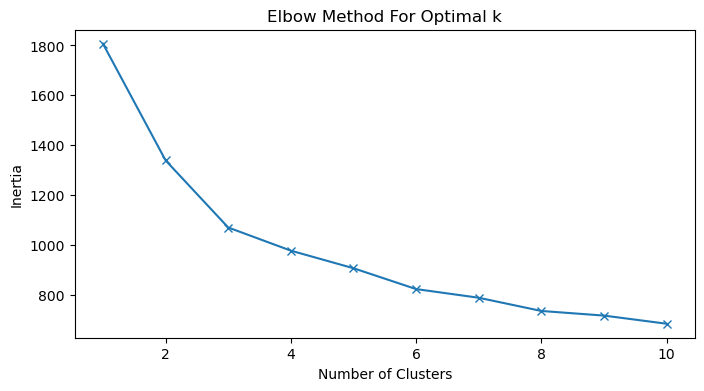

In [20]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
plt.figure(figsize = (8,4))
plt.plot(range(1,11), inertias, marker = "x")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
umap_2d = UMAP(n_components=2, init="random", random_state=0)
umap_result = umap_2d.fit_transform(X_scaled)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(umap_result)
umap_centers = kmeans.cluster_centers_

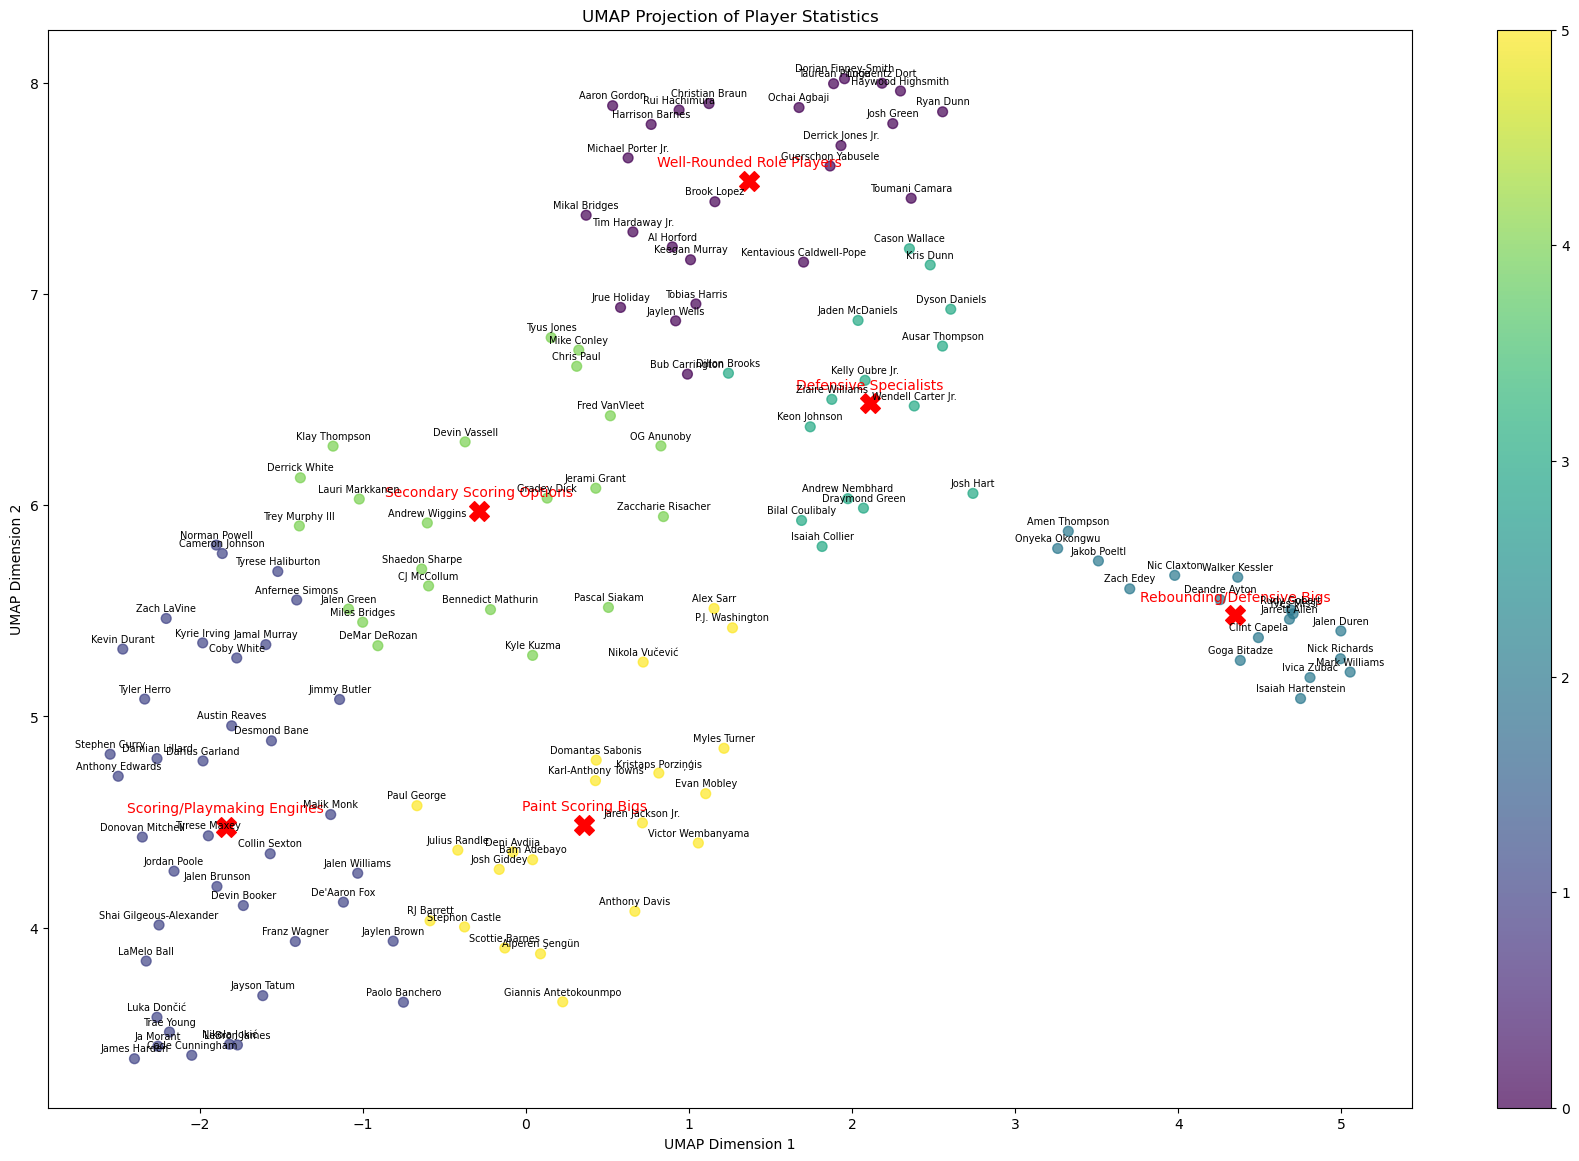

In [ ]:
plt.figure(figsize=(22 , 14))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans.labels_, s=50, alpha=0.7, cmap='viridis')
plt.scatter(umap_centers[:, 0], umap_centers[:, 1], c='red', s=200, marker='X', label='Cluster Centers')
### Annotate cluster centers with descriptive labels
labels = [
    'Well-Rounded Role Players',
    'Scoring/Playmaking Engines',
    'Rebounding/Defensive Bigs',
    'Defensive Specialists',
    'Secondary Scoring Options',
    'Paint Scoring Bigs'
]
for i, label in enumerate(labels):
    plt.annotate(label, (umap_centers[i, 0], umap_centers[i, 1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='red')

###
for i in range(umap_result.shape[0]):
    plt.annotate(df_filtered["Player"].values[i], (umap_result[i, 0], umap_result[i, 1]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=7)
plt.title('UMAP Projection of Player Statistics')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter)
plt.legend()
plt.show()

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, kmeans.labels_, test_size=0.2, random_state=42)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)
y_pred = svm_model.predict(X_test)
print(f"Accuracy: {100*accuracy_score(y_test, y_pred)}%")
print(f"Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 75.0%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.70      0.78      0.74         9
           2       1.00      1.00      1.00         5
           4       0.57      0.80      0.67         5
           5       0.67      0.33      0.44         6

    accuracy                           0.75        28
   macro avg       0.79      0.78      0.77        28
weighted avg       0.76      0.75      0.74        28

